In [196]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

sns.set(style="darkgrid")


In [197]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 90), quadrant_column] = 'I'
    df.loc[valid_mask & (angles >= 90) & (angles < 180), quadrant_column] = 'II'
    df.loc[valid_mask & (angles >= 180) & (angles < 270), quadrant_column] = 'III'
    df.loc[valid_mask & (angles >= 270), quadrant_column] = 'IV'


    return df

In [198]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'II')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'III'))

    v_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'II'))

    b_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'II'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

# Task a
Read all participants' data for task **a**. Add a column with participant number.

In [199]:
df = pd.DataFrame()
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))

560


In [200]:
# rename the columns
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval', 'nPart']

In [201]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip
39,39,63.783178,107.167165,72.408710,168.050243,1740393867497,1740393873111,1740393875779,1593.517284,492.275472,1,II,II,N
17,17,38.671871,134.345153,26.304140,156.879151,1740393523101,1740393529041,1740393536399,1109.843892,1084.760137,1,II,II,N
16,16,41.396595,235.389689,30.416356,233.189292,1740393508351,1740393512235,1740393518600,1275.893763,880.519090,1,III,III,N
15,15,34.161208,142.054150,33.948603,155.286823,1740393493217,1740393498143,1740393503850,1113.616165,1428.143730,1,II,II,N
14,14,37.778819,31.266457,35.019536,67.539416,1740393478951,1740393483186,1740393488717,929.024682,1529.994240,1,I,I,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,23,26.922922,314.526449,25.271163,313.327606,1740675527143,1740675537623,1740675545293,1589.034590,1562.982508,14,IV,IV,N
22,22,78.516487,240.697477,63.015762,230.042451,1740675508845,1740675519578,1740675522642,780.688746,438.147302,14,III,III,N
21,21,41.754530,55.773344,35.900321,40.601295,1740675488163,1740675498950,1740675504343,1277.378959,868.974858,14,I,I,N
28,28,137.014643,278.830842,74.366030,296.961099,1740675630691,1740675637114,1740675639724,1426.249877,221.581350,14,IV,IV,N


Show number and kind of flip per participant

TBD: compute average number of flips per participant, of the different kinds. Plot histogram of number of flips.

In [202]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')
errors_df

,nPart,flip,Count
0,1,H,1
1,1,N,38
2,1,V,1
3,2,N,39
4,2,V,1
5,3,N,37
6,3,V,3
7,4,N,40
8,5,B,1
9,5,N,38


In [203]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 28


In [204]:
dfN.tail()

### Histograms of generated speed and angle. 
Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes. 

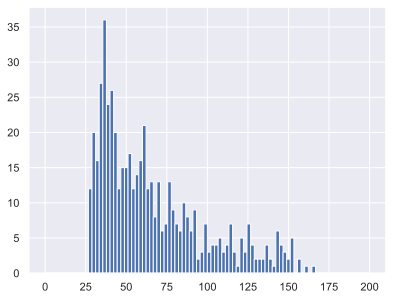

In [205]:
plt.hist(dfN.soundSpeed, bins=90, range = (0, 200));

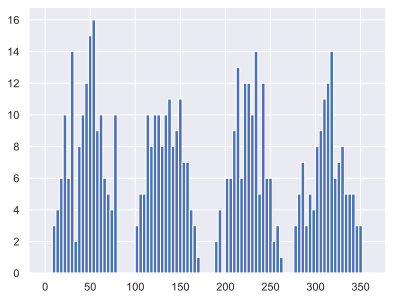

In [206]:
plt.hist(dfN.soundAngle,bins=90, range=(0,360));

### Statistics of angle and speed error
TBD: 
- Normality test
- skewness and kurtosis
- significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [207]:
errAngle = dfN.movAngle - dfN.soundAngle
print(np.mean(errAngle))
print(np.std(errAngle))

-0.17311413340902704
13.764510210163264


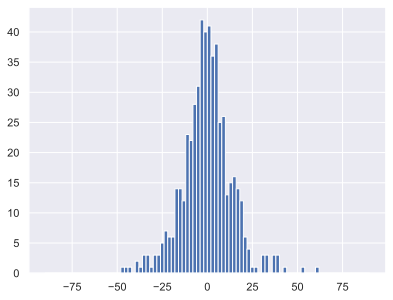

In [208]:
plt.hist(errAngle, bins=90, range = (-90,90));

In [209]:
errSpeed = dfN.soundSpeed - dfN.movSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))

-12.429382503907263
42.2854716826156


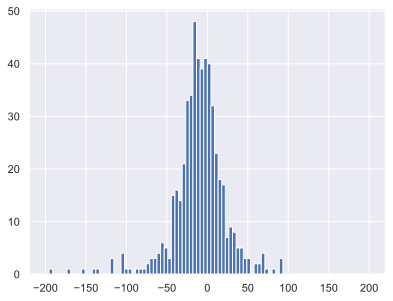

In [210]:
plt.hist(errSpeed, bins=90, range=(-200, 200));

Do participant think longer when they have smaller errors? Apparently not.

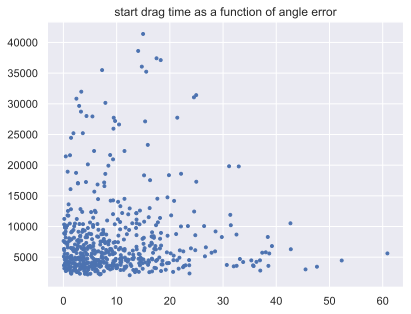

In [211]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN.startDragTime-dfN.soundStart), '.')
ax.set_title('start drag time as a function of angle error');

# Task b
Read all participants' data for task **b**. Add a column with participant number.

In [212]:
df = pd.DataFrame()
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))

560


In [213]:
# rename the columns
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval', 'nPart']

In [214]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip
0,0,82.693867,284.623240,158.610628,275.445759,1740394165144,1740394169714,1740394167503,1740394171707,1740394167693,1436.984860,374.928989,1,IV,IV,N
18,18,103.275445,194.975575,41.726087,206.156105,1740394358990,1740394360687,1740394362763,1740394361488,1740394364394,300.698205,1124.137627,1,III,III,N
17,17,43.859163,306.877006,33.227196,315.493530,1740394348874,1740394353911,1740394351291,1740394355177,1740394352579,1139.824101,855.089055,1,IV,IV,N
16,16,44.814959,317.574680,40.320075,314.265130,1740394339524,1740394341710,1740394344021,1740394342776,1740394345060,906.878982,992.278235,1,IV,IV,N
15,15,47.295864,154.388125,30.871862,127.869972,1740394327691,1740394330588,1740394334477,1740394332171,1740394335708,703.421001,1467.372329,1,II,II,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,22,43.782762,126.314578,60.961123,118.877663,1740674643799,1740674649866,1740674652412,1740674650885,1740674652974,1157.007942,850.360137,14,II,II,N
21,21,29.461801,320.269368,37.545060,313.304155,1740674631733,1740674638831,1740674636617,1740674639996,1740674637715,1324.045480,1593.086734,14,IV,IV,N
20,20,35.918993,130.258828,41.901548,147.703447,1740674620050,1740674624237,1740674626589,1740674625084,1740674627930,1292.415653,1094.452513,14,II,II,N
29,29,70.978061,290.078116,57.984746,302.726148,1740674723733,1740674737121,1740674735297,1740674738078,1740674735912,1231.181478,450.015295,14,IV,IV,N


Show number and kind of flip per participant

TBD: compute average number of flips per participant, of the different kinds. Plot histogram of number of flips.

In [215]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')
errors_df

,nPart,flip,Count
0,1,H,1
1,1,N,37
2,1,V,2
3,2,N,40
4,3,N,40
5,4,N,39
6,4,V,1
7,5,N,38
8,5,V,2
9,6,N,40


In [216]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips =  8


In [217]:
dfN.tail()

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip
22,22,43.782762,126.314578,60.961123,118.877663,1740674643799,1740674649866,1740674652412,1740674650885,1740674652974,1157.007942,850.360137,14,II,II,N
21,21,29.461801,320.269368,37.545060,313.304155,1740674631733,1740674638831,1740674636617,1740674639996,1740674637715,1324.045480,1593.086734,14,IV,IV,N
20,20,35.918993,130.258828,41.901548,147.703447,1740674620050,1740674624237,1740674626589,1740674625084,1740674627930,1292.415653,1094.452513,14,II,II,N
29,29,70.978061,290.078116,57.984746,302.726148,1740674723733,1740674737121,1740674735297,1740674738078,1740674735912,1231.181478,450.015295,14,IV,IV,N
39,39,57.293108,324.189592,54.441267,313.604610,1740674843715,1740674853520,1740674851762,1740674854319,1740674852523,645.685085,894.921761,14,IV,IV,N


### Histograms of generated speed and angle.

Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes.


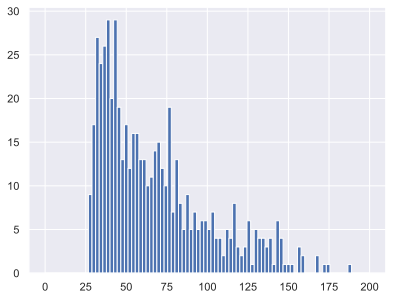

In [218]:
plt.hist(df.movSpeed, bins=90, range=(0, 200));

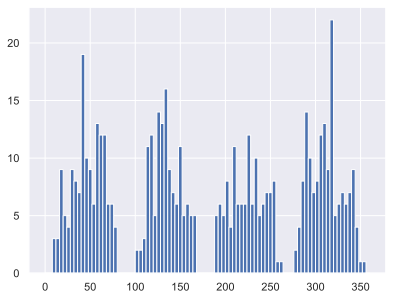

In [219]:
plt.hist(dfN.movAngle,bins=90, range=(0,360));

### Statistics of angle and speed error
TBD: 
- Normality test
- skewness and kurtosis
- significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [220]:
errAngle = dfN.tapAngle - dfN.movAngle
print(np.mean(errAngle))
print(np.std(errAngle))

0.26277453852023686
12.730787169412


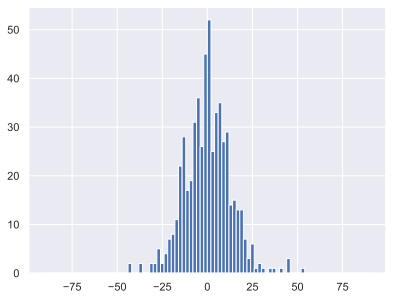

In [221]:
plt.hist(errAngle, bins=90, range=(-90,90));

13.927316790183534
26.470908845653174


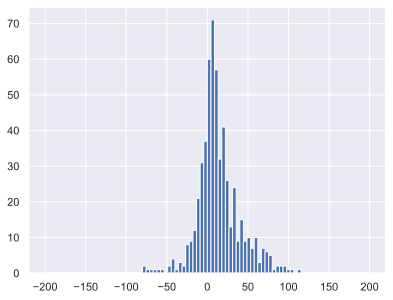

In [222]:
errSpeed = dfN.movSpeed - dfN.tapSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))
plt.hist(errSpeed, bins=90, range=(-200,200));

Do participant think longer when they have smaller errors? Apparently not.

Text(0.5, 1.0, 'start drag time as a function of angle error')

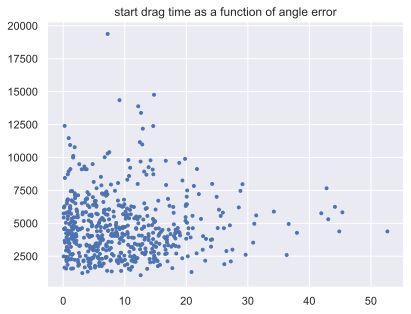

In [223]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN.tapHor-dfN.movStart), '.')
ax.set_title('start drag time as a function of angle error')

### TBD
- regression of speed error vs stimulus angle (deviation from diagonal)
- regression of angle error vs stimulus angle (deviation from diagonal)

### TBD
Comparison of speed and angle error between Task A and Task B